In [1]:
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [2]:
data = pd.read_csv("Emotion_Data.csv" )

In [3]:
data.sample(10)

,Comment,Emotion
1979,i feel wimpy for complaining about taking cred...,fear
623,i feel so peaceful so i know i made the right ...,joy
2364,i really feel like i m wading in dangerous wat...,anger
602,i feel like i cant take it anymore i told my b...,anger
2356,i have already said i am one of many feeling t...,fear
2472,i was feeling pretty well in mid october,joy
4597,i am feeling anxious that im not out watching ...,fear
93,the possibility of having failed the examination,fear
2736,i dont really connect with the main character ...,joy
5561,i dont want to pretend i am someone and i am n...,joy


In [4]:
data["Emotion"].value_counts()

Emotion
anger    2000
joy      2000
fear     1937
Name: count, dtype: int64

In [5]:
data.isnull().sum()

Comment    0
Emotion    0
dtype: int64

(array([1937.,    0.,    0.,    0.,    0., 2000.,    0.,    0.,    0.,
        2000.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

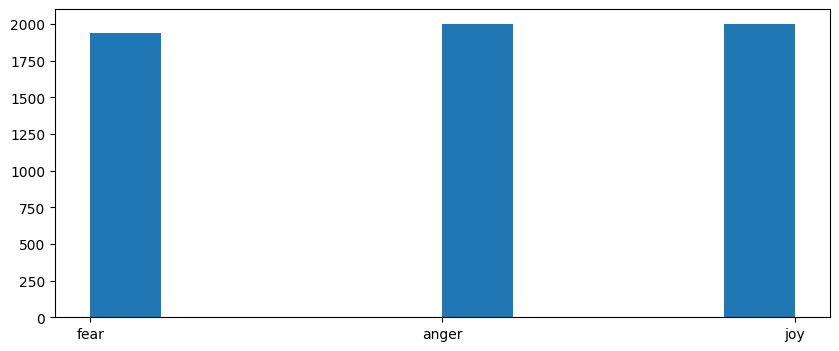

In [6]:
plt.figure(figsize=(10,4) )
plt.hist(data["Emotion"]  )

### remove special charchater , tags and covert emoji into emoji unicode

In [7]:
import re
import emoji
sents=[]
for sent in data["Comment"]:
    sent = re.sub(r'' , "" , sent)
    sent = re.sub(r'[^a-zA-Z0-9\s]' , "" , sent)
    sent = sent.lower()
    sent = emoji.demojize(sent)
    sents.append(sent)
data['Comment'] = sents

In [8]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

###  lemmatization and remove stopwords

In [9]:
stopwords = set(stopwords.words("english"))
lemmatizer=WordNetLemmatizer()
new_text_arr =[]
corpus_for_word2vec = []
for sent in data["Comment"]:
   text = word_tokenize(sent)
   text =[lemmatizer.lemmatize(word) for word in text if word not in stopwords]
   text = " ".join(text)
   new_text_arr.append(sent)
   corpus_for_word2vec.append(text)

data["Comment"] = new_text_arr

In [30]:
data.head()
data["Emotion"].value_counts()

Emotion
anger    2000
joy      2000
fear     1937
Name: count, dtype: int64

In [11]:
from sklearn.model_selection import train_test_split
x_train , x_test , y_train ,y_test = train_test_split(data[["Comment"]] , data["Emotion"]  , test_size =0.3 , random_state =42)

In [12]:
from sklearn.preprocessing import LabelEncoder
Label_encoder = LabelEncoder()
Label_encoder.fit(y_train)

LabelEncoder()

In [13]:
y_train = Label_encoder.transform(y_train)
y_test = Label_encoder.transform(y_test)

### TF_IDF (text to vector)

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf = TfidfVectorizer()
tf_idf.fit(x_train["Comment"])

TfidfVectorizer()

In [15]:
x_train=tf_idf.transform(x_train["Comment"]).toarray()
x_test=tf_idf.transform(x_test['Comment']).toarray()

In [16]:
x_train=pd.DataFrame(x_train)
x_test=pd.DataFrame(x_test)
x_train.shape

(4155, 7250)

### support vector machine

In [17]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(x_train, y_train)

SVC()

In [18]:
y_pred = svc.predict(x_test)

In [19]:
from sklearn.metrics import accuracy_score
print(f"accuracy_score of svc :-  {accuracy_score(y_test ,y_pred)}")

accuracy_score of svc :-  0.9001122334455668


In [41]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(svc, x_train, y_train, cv=5, scoring='accuracy')

In [ ]:
mean_accuracy = scores.mean()
print("Mean Accuracy:", mean_accuracy)

### Random Forest Classifier

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
RandomForest = RandomForestClassifier()
RandomForest.fit(x_train , y_train)

RandomForestClassifier()

In [21]:
y_pred = RandomForest.predict(x_test)

In [22]:
print(f"accuracy_score of random forest :-  {accuracy_score(y_test ,y_pred)}")

accuracy_score of random forest :-  0.9102132435465768


In [34]:
from xgboost import XGBClassifier
bst = XGBClassifier(n_estimators=130, max_depth=8 ,learning_rate=0.1, objective='multi:softmax')
bst.fit(x_train, y_train)
# make predictions
preds = bst.predict(x_test)
y_pred= bst.predict(x_test)
from sklearn.metrics import accuracy_score
print("accuracy_score :- " , accuracy_score(y_test ,y_pred))

accuracy_score :-  0.9259259259259259


In [39]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential([
    Dense(128, input_dim=x_train.shape[1], activation='relu'),
    Dropout(0.7),
    Dense(50, activation='relu'),
    Dropout(0.7),
    Dense(25, activation='relu'),
    Dropout(0.7),
    Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=30, batch_size=10, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

C:\Users\rahul\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
333/333 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.3410 - loss: 1.1013 - val_accuracy: 0.3369 - val_loss: 1.0989
Epoch 2/30
333/333 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.3646 - loss: 1.0970 - val_accuracy: 0.3646 - val_loss: 1.0954
Epoch 3/30
333/333 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.3442 - loss: 1.0929 - val_accuracy: 0.5187 - val_loss: 1.0728
Epoch 4/30
333/333 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.4198 - loss: 1.0487 - val_accuracy: 0.7545 - val_loss: 0.9435
Epoch 5/30
333/333 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.6027 - loss: 0.9166 - val_accuracy: 0.8123 - val_loss: 0.7097
Epoch 6/30
333/333 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.7381 - loss: 0.6986 - val_accuracy: 0.8532 - val_loss: 0.5063
Epoch 7/30
333/333 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8022 - loss: 0.5360 - val_accuracy: 0.8809 - val_loss: 0.4039
Epoch 8/30
333/333 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8635 - loss: 0.4335 - val_accu

#  Convert Text to Vector using Word2vec 

In [40]:
from gensim.models import Word2Vec
import gensim.downloader as api
model = api.load('word2vec-google-news-300')

# Define a function to apply average Word2Vec embedding
def apply_avg2wordvec(sent):
    sent = [word for word in sent if word in model.index_to_key]
    if not sent:  # Check if sent is empty after filtering
        return np.zeros(model.vector_size)  # Return zero vector if sent is empty
    else:
        return np.mean(model[sent], axis=0)

# Apply average Word2Vec embedding to each sentence in corpus
vector_corpus = [apply_avg2wordvec(s) for s in corpus_for_word2vec]

# Convert the list of vectors to numpy array
x = np.array(vector_corpus)

# Split dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, df["Liked"], test_size=0.2, random_state=42)

KeyboardInterrupt: 

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=110)
rfc.fit(x_train , y_train)
y_pred = rfc.predict(x_test)
print(f"accuracy_score {accuracy_score(y_test ,y_pred)}")

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(x_train , y_train)
y_pred = lr.predict(x_test)
print(f"accuracy_score {accuracy_score(y_test ,y_pred)}")